# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Example-of-Image" data-toc-modified-id="Example-of-Image-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Example of Image</a></div><div class="lev1 toc-item"><a href="#Data-loading-and-Prepocessing" data-toc-modified-id="Data-loading-and-Prepocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data loading and Prepocessing</a></div><div class="lev1 toc-item"><a href="#Models" data-toc-modified-id="Models-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models</a></div><div class="lev2 toc-item"><a href="#Fully-Convolutional-Network" data-toc-modified-id="Fully-Convolutional-Network-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Fully Convolutional Network</a></div><div class="lev1 toc-item"><a href="#UNet" data-toc-modified-id="UNet-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>UNet</a></div><div class="lev1 toc-item"><a href="#Training" data-toc-modified-id="Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training</a></div><div class="lev2 toc-item"><a href="#Fully-Convolutionnal" data-toc-modified-id="Fully-Convolutionnal-51"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Fully Convolutionnal</a></div><div class="lev2 toc-item"><a href="#U-Net" data-toc-modified-id="U-Net-52"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>U-Net</a></div><div class="lev1 toc-item"><a href="#Results" data-toc-modified-id="Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results</a></div><div class="lev2 toc-item"><a href="#Fully-Convolutional" data-toc-modified-id="Fully-Convolutional-61"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Fully Convolutional</a></div><div class="lev2 toc-item"><a href="#U-Net" data-toc-modified-id="U-Net-62"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>U-Net</a></div>

In [9]:
%matplotlib inline
import importlib
from scipy.misc import imread, imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
import numpy as np
import time
import random
from PIL import Image
import os
import pickle
#import bcolz
#from bcolz_array_iterator import BcolzArrayIterator
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
import keras.backend as K

from keras.layers import Conv2D, UpSampling2D, Lambda, ZeroPadding2D
from keras.models import Sequential

# from vgg16_avg import VGG16_Avg
#from vgg16 import VGG16

import sys
# sys.path.append('../utilities')
#import utils2; importlib.reload(utils2)
#from utils2 import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.transform as trans
import random as r
from keras.optimizers import Adam
from skimage.color import rgb2grey

from skimage import feature
import skimage

# Example of Image

/Users/remus/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


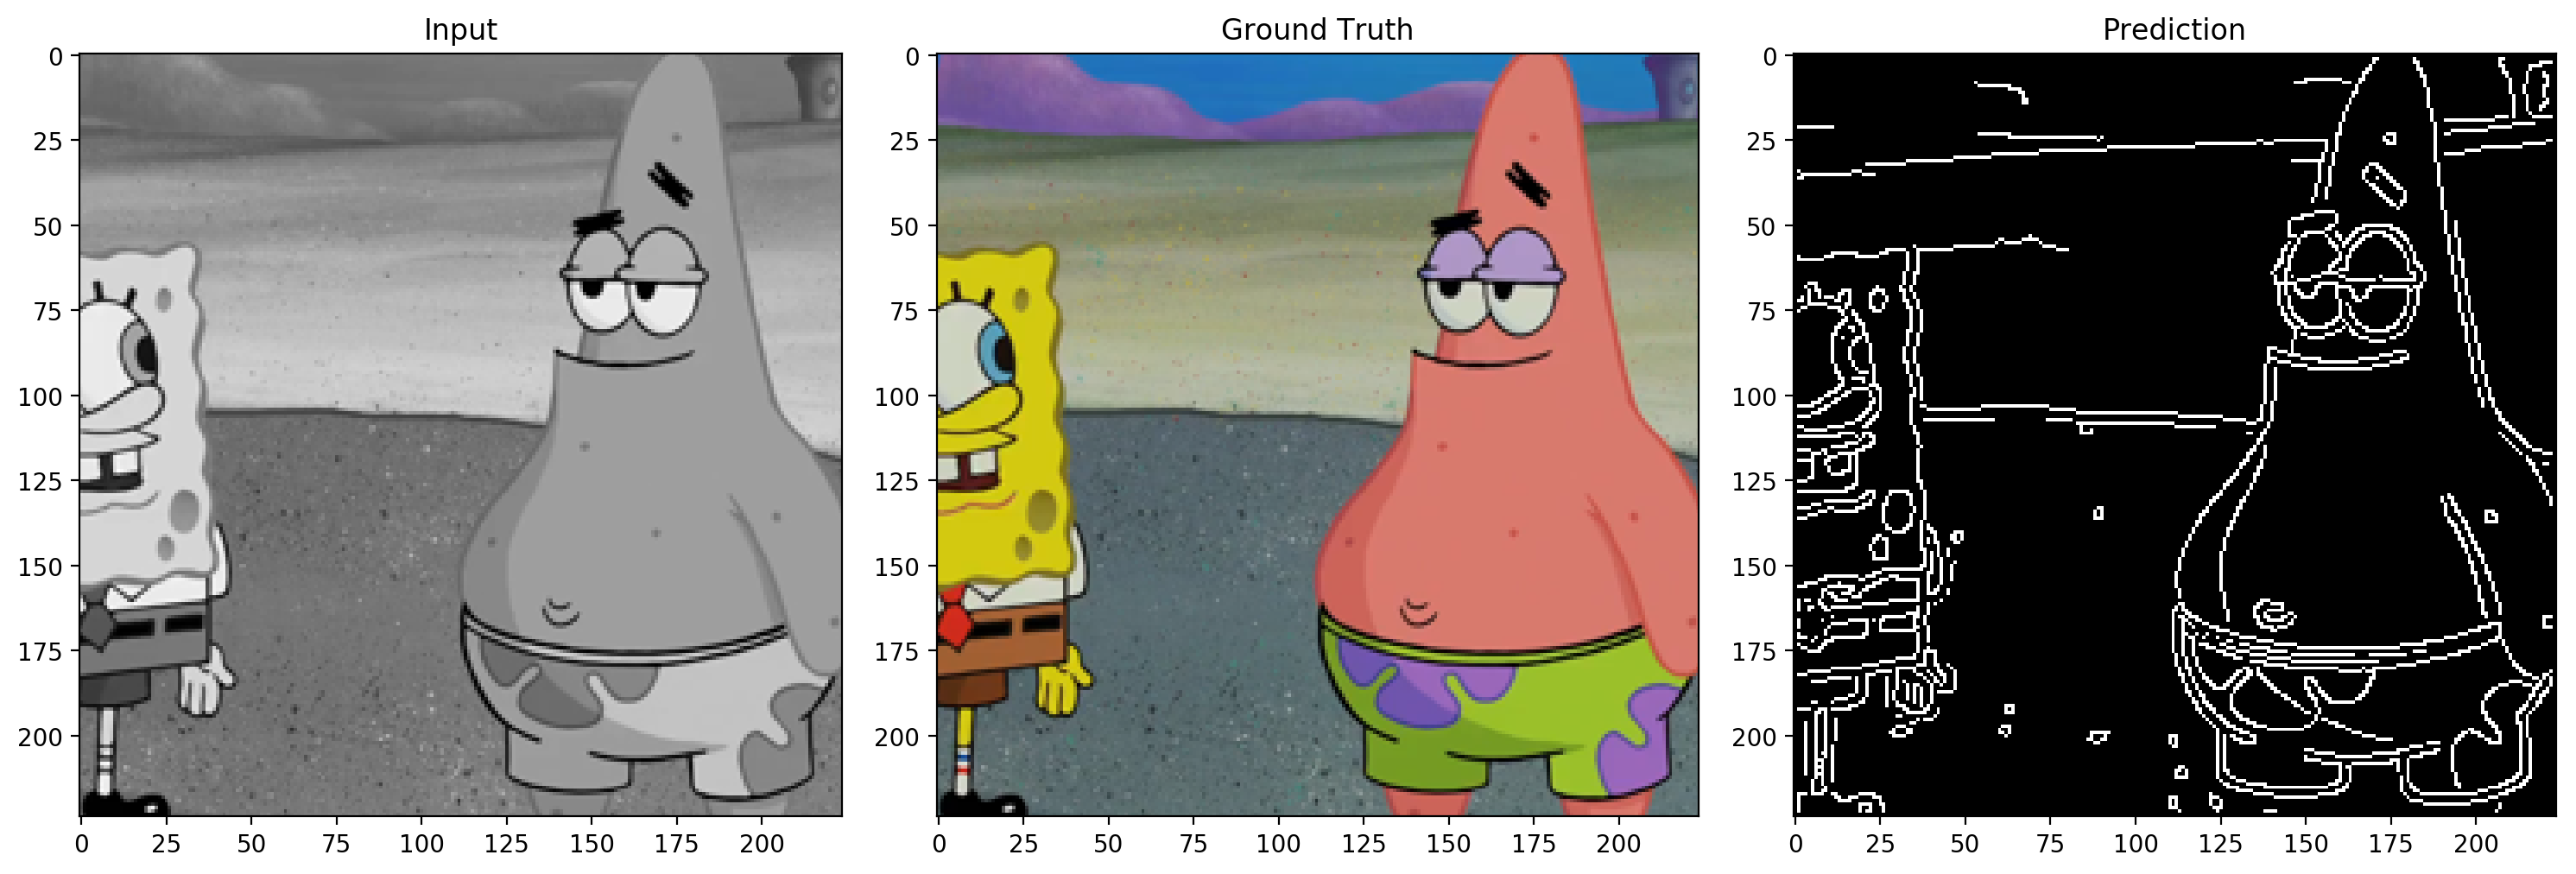

In [11]:
file = 'images/Spongebob/img/frame_0001.png'

img = io.imread(file)/255
greyscale = rgb2grey(img)
canny = feature.canny(greyscale)

plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.title('Input')
plt.imshow(greyscale, cmap='gray')

plt.subplot(132)
plt.title('Ground Truth')
skimage.io.imshow(img)

plt.subplot(133)
plt.title('Prediction')
plt.imshow(canny, cmap='gray');

In [12]:
np.array(greyscale).shape

(224, 224)

# Data loading and Prepocessing

In [13]:
import glob
def create_data(src, mask, label=False):
    files = glob.glob(src + mask, recursive=True)
    imgs = []
    imgs_grey = []
    for file in files:
        feat_grey = []
        img = io.imread(file)
        # Normalization by Louis
        img = img / 255
        if label:
            img[img == 4] = 1
            img[img != 1] = 0
            img = img.astype('float32')
        else:
            img = img
        imgs.append(img)
        img_grey = rgb2grey(img)
        feat_grey.append(img_grey)
        canny = feature.canny(img_grey)
        feat_grey.append(canny)
        imgs_grey.append(feat_grey)
    name = 'y'
    np.save(name, np.array(imgs).astype('float32'))
    print('Saved', len(files), 'to', name)
    name = 'x'
    np.save(name, np.array(imgs_grey).transpose(0,2,3,1).astype('float32'))
    print('Saved', len(files), 'to', name)

In [8]:
create_data('images/Spongebob/img/', '**.png')

Saved 1742 to y
Saved 1742 to x


In [14]:
x = np.load('x.npy')
print('x: ', x.shape)
y = np.load('y.npy')
print('y:', y.shape)

x:  (1742, 224, 224, 2)
y: (1742, 224, 224, 3)


# Models

## Fully Convolutional Network

In [15]:
def colorization_net(arr):
    inputs = Input(arr.shape[1:])
    conv1 = Conv2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Conv2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Conv2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Conv2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Conv2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    up1 = UpSampling2D(size=(2, 2))(pool4)
    conv5 = Convolution2D(128, 2, 2, activation='relu',
                          border_mode='same')(up1)

    up2 = UpSampling2D(size=(2, 2))(conv5)
    conv6 = Convolution2D(64, 2, 2, activation='relu', border_mode='same')(up2)

    up3 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(33, 2, 2, activation='relu', border_mode='same')(up3)

    up4 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(3, 2, 2, activation='relu', border_mode='same')(up4)

    #model = Model(input=inputs, output=conv8)
    outputs = conv8

    return Model(inputs=inputs, outputs=conv8)  # model

# UNet

In [16]:
def conv_block(x, filters, size, stride=(2, 2), mode='same', act=True):
    x = Convolution2D(filters, size, size,
                      subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x


def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1, 1))
    x = conv_block(x, nf, 3, (1, 1), act=False)
    return merge([x, ip], mode='sum')

In [17]:
from keras.models import Input, Model
from keras.layers import Conv2D, Concatenate, MaxPooling2D, Reshape
from keras.layers import UpSampling2D, Activation, Permute


def level_block(m, dim, depth, factor, acti):
    if depth > 0:
        n = Conv2D(dim, 3, activation=acti, padding='same')(m)
        n = Conv2D(dim, 3, activation=acti, padding='same')(n)
        m = MaxPooling2D()(n)
        m = level_block(m, int(factor*dim), depth-1, factor, acti)
        m = UpSampling2D()(m)
        m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        m = Concatenate(axis=3)([n, m])
    m = Conv2D(dim, 3, activation=acti, padding='same')(m)
    return Conv2D(dim, 3, activation=acti, padding='same')(m)


def UNet(img_shape, n_out=1, dim=64, depth=4, factor=2, acti='relu', flatten=False):
    i = Input(shape=img_shape)
    o = level_block(i, dim, depth, factor, acti)
    o = Conv2D(n_out, (1, 1))(o)
    if flatten:
        o = Reshape(n_out, img_shape[0] * img_shape[1])(o)
        o = Permute((2, 1))(o)
    o = Activation('relu')(o)
    return Model(inputs=i, outputs=o)

# Training 

## Fully Convolutionnal

In [ ]:
model = colorization_net(x)
model.compile(optimizer=Adam(lr=0.01), loss='mse')
model.fit(x, y, validation_split=0.2, epochs=1, batch_size=8)
# model.fit(x, y, validation_split=0.2, epochs=50, batch_size=8)

/Users/remus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/remus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/Users/remus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  import sys
/Users/remus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/Users/remus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update y

Train on 1393 samples, validate on 349 samples
Epoch 1/1
 360/1393 [======>.......................] - ETA: 10:00 - loss: 5441600.4669

## U-Net

In [38]:
model_u = UNet(x.shape[1:], n_out = 3, dim=8, factor=1)
model_u.load_weights('unet.h5')

In [39]:
model_u.compile(optimizer=Adam(lr=0.001), loss='mse')

In [ ]:
model_u.fit(x[:500], y[:500], validation_split=0.2, epochs=20, batch_size=8)

Train on 400 samples, validate on 100 samples
Epoch 1/20
400/400 [==============================] - 82s 205ms/step - loss: 8114.6136 - val_loss: 1963.6841
Epoch 2/20
400/400 [==============================] - 84s 210ms/step - loss: 1615.7997 - val_loss: 1215.7995
Epoch 3/20
400/400 [==============================] - 83s 207ms/step - loss: 1165.4337 - val_loss: 995.5214
Epoch 4/20
400/400 [==============================] - 85s 212ms/step - loss: 1008.0957 - val_loss: 925.4209
Epoch 5/20
400/400 [==============================] - 80s 201ms/step - loss: 937.9732 - val_loss: 868.5740
Epoch 6/20
400/400 [==============================] - 78s 194ms/step - loss: 901.1843 - val_loss: 840.9958
Epoch 7/20
400/400 [==============================] - 80s 199ms/step - loss: 882.9988 - val_loss: 825.8709
Epoch 8/20
400/400 [==============================] - 78s 196ms/step - loss: 881.3233 - val_loss: 818.5375
Epoch 9/20
400/400 [==============================] - 79s 197ms/step - loss: 860.2011 - val_

In [27]:
model_.save_weights('unet.h5')

# Results

## Fully Convolutional

In [ ]:
pred = model.predict(x[:50])
# pred = np.clip(pred,0,255)/255
pred = np.clip(pred[i], 0, 1)

In [ ]:
import random as r
import skimage
for n in range(20):
    i = int(r.random() * pred.shape[0])
    plt.figure(figsize=(15, 10))

    plt.subplot(131)
    plt.title('Input')
    plt.imshow(x[i, :, :, 0], cmap='gray')

    plt.subplot(132)
    plt.title('Ground Truth')
#     skimage.io.imshow(y[i]/255)
    skimage.io.imshow(y[i])

    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(pred[i])
#     plt.imshow(no.clip(pred[i], 0, 1))
    plt.show()

## U-Net

In [28]:
pred_u = model_u.predict(x[:50])
# pred_u = np.clip(pred_u,0,255)/255
pred_u = np.clip(pred[i], 0, 1)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


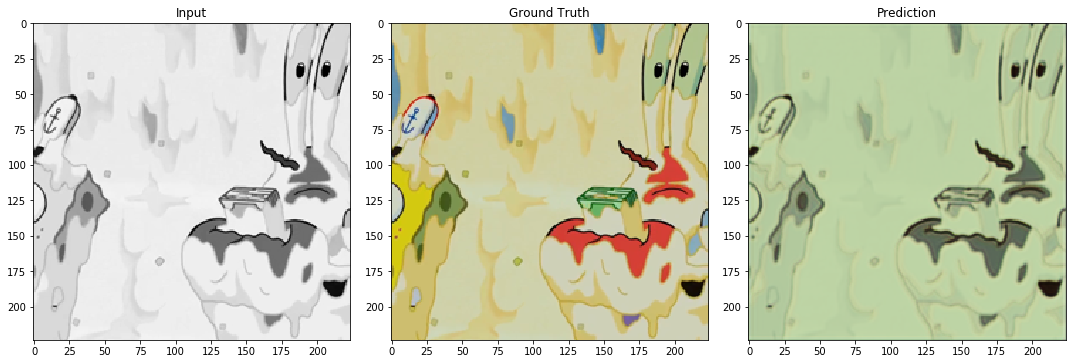

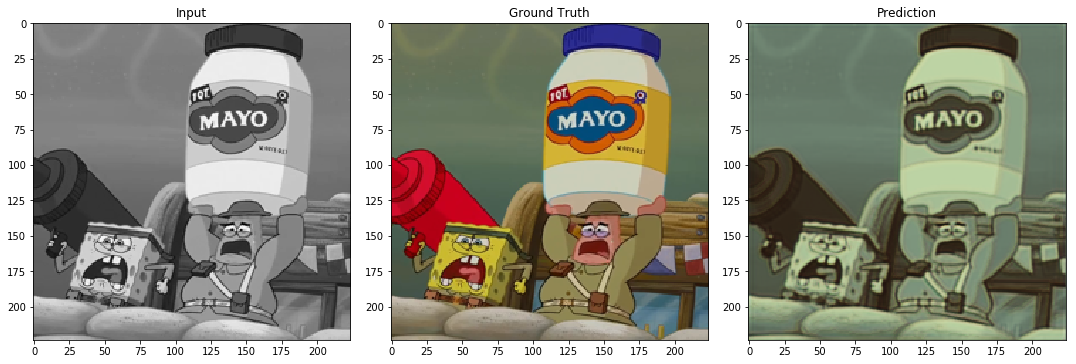

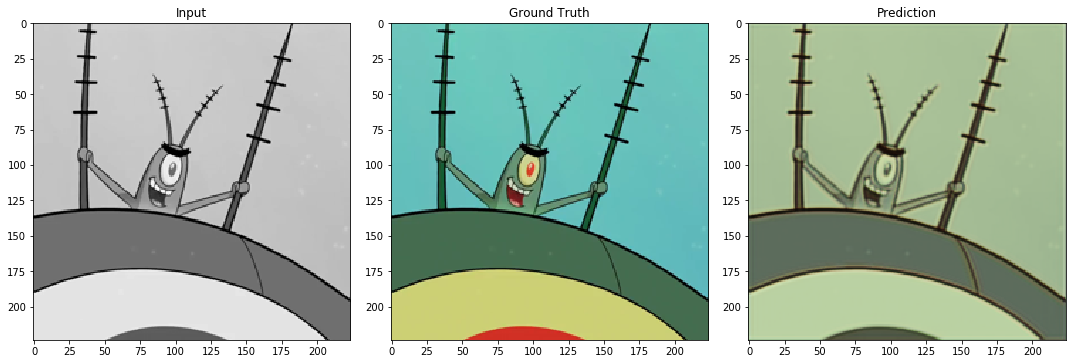

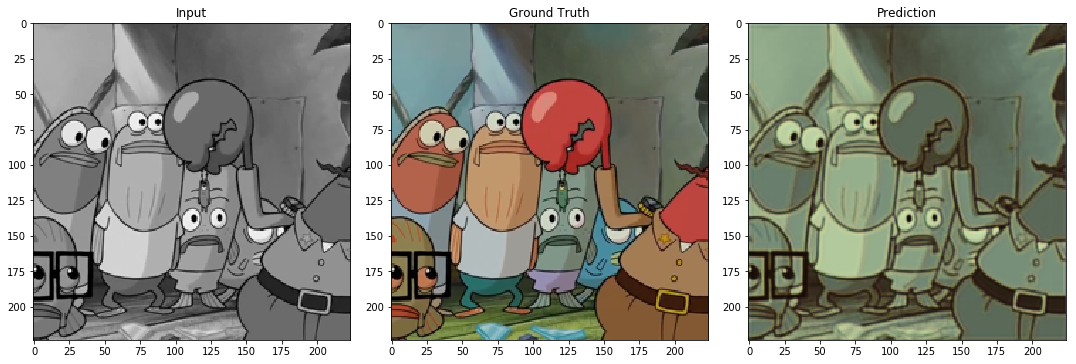

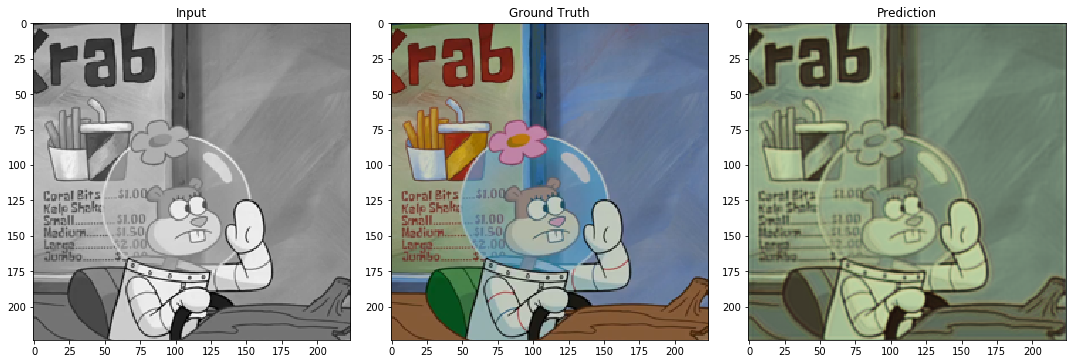

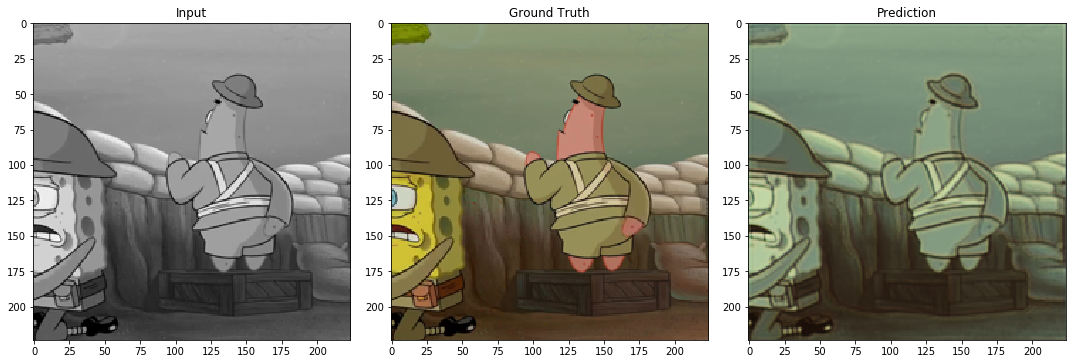

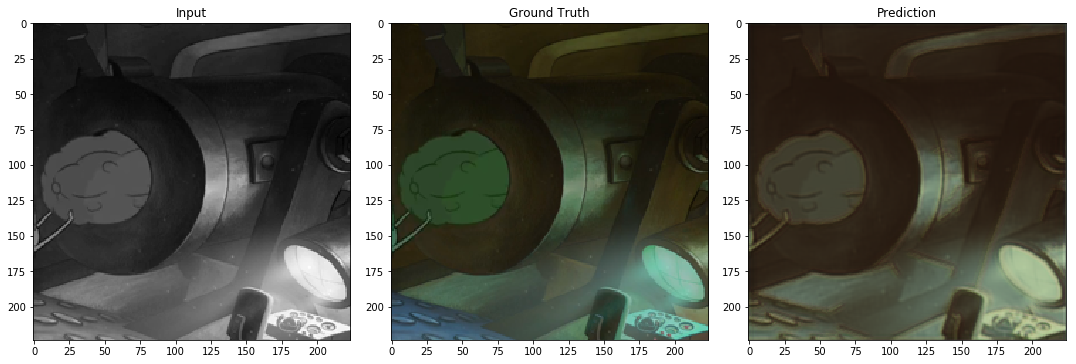

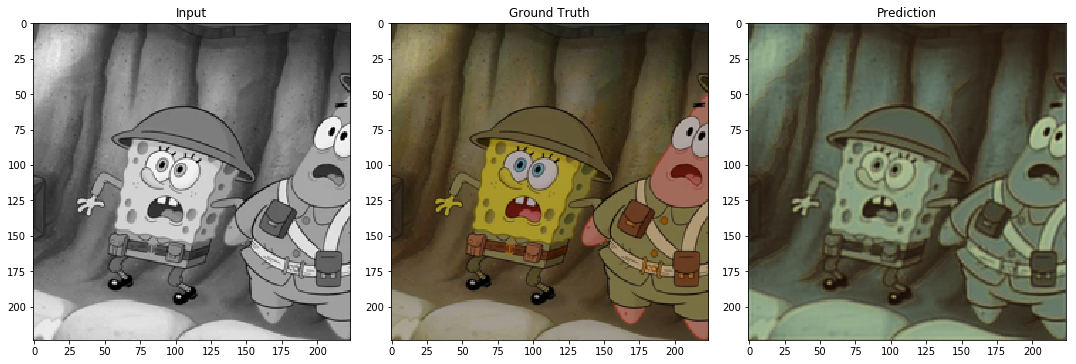

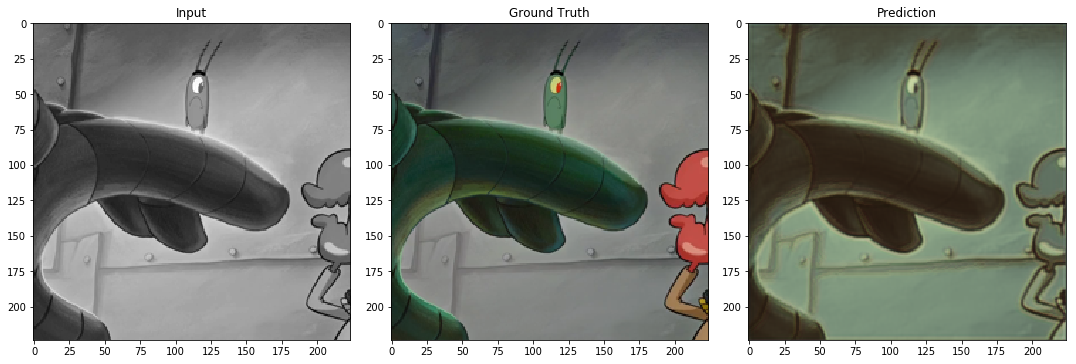

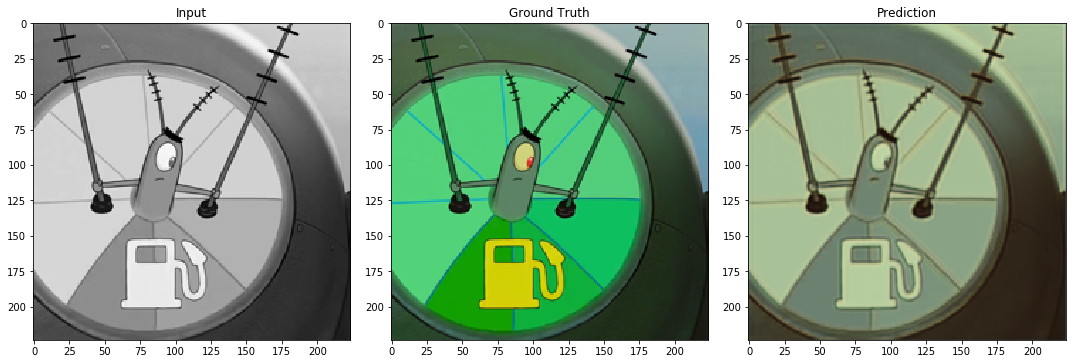

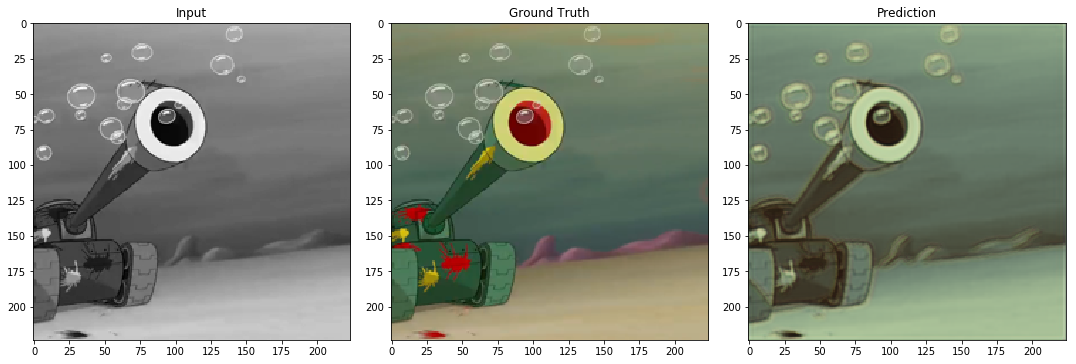

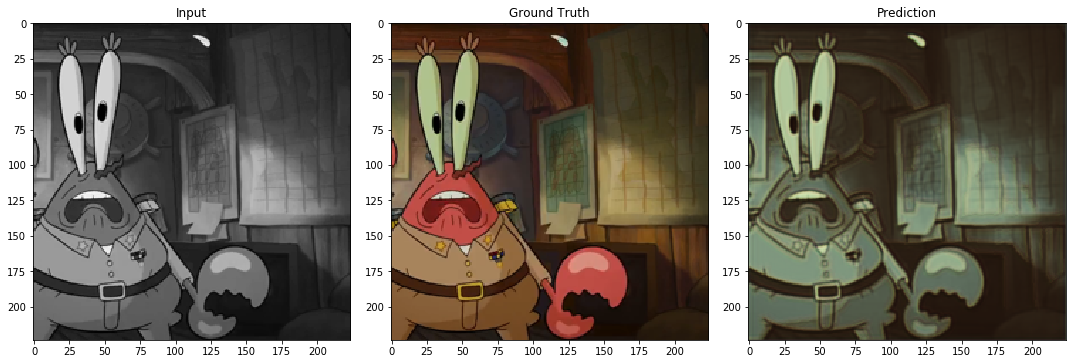

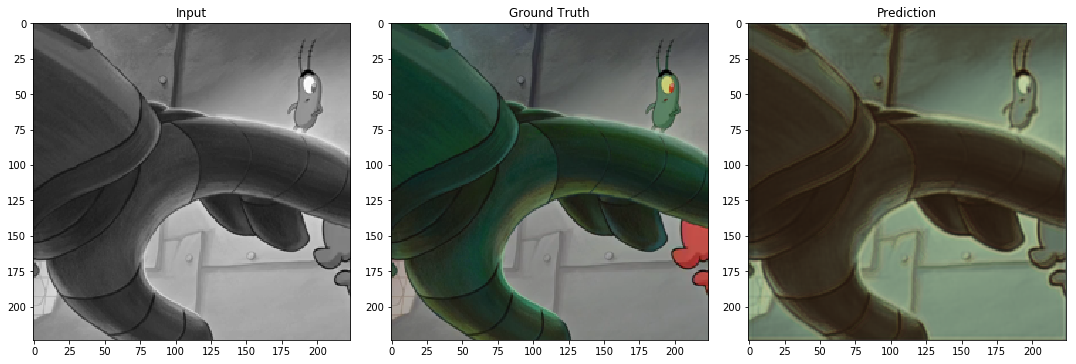

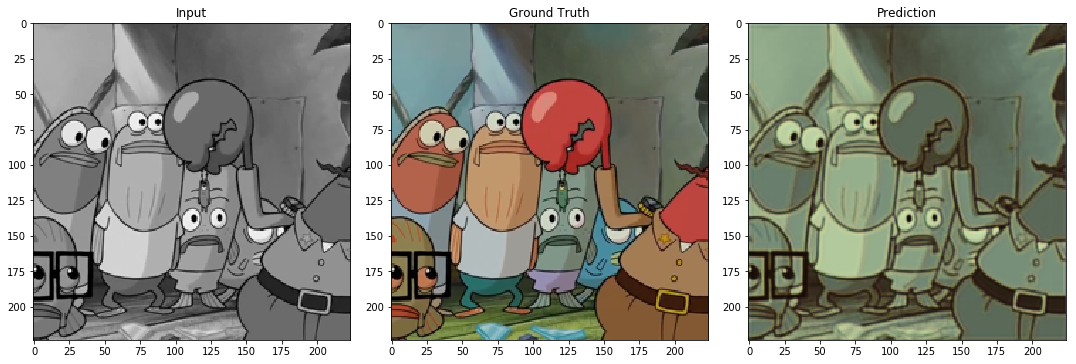

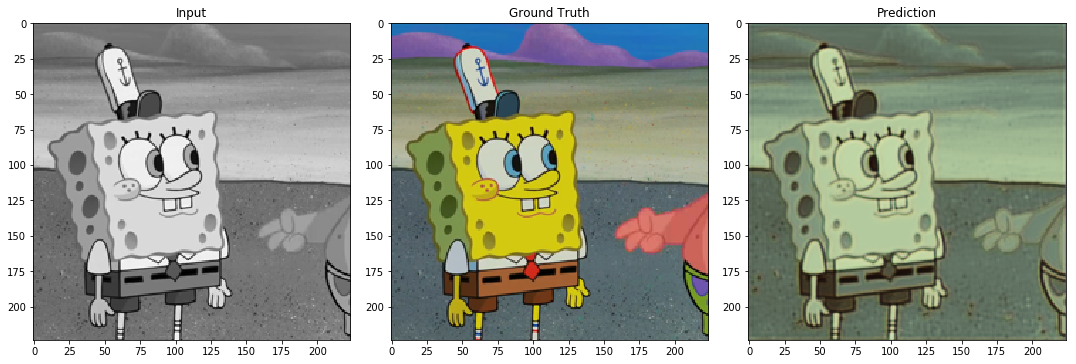

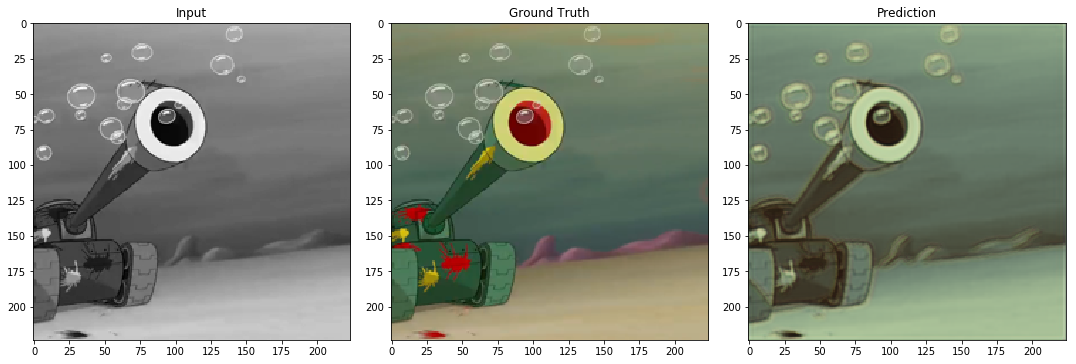

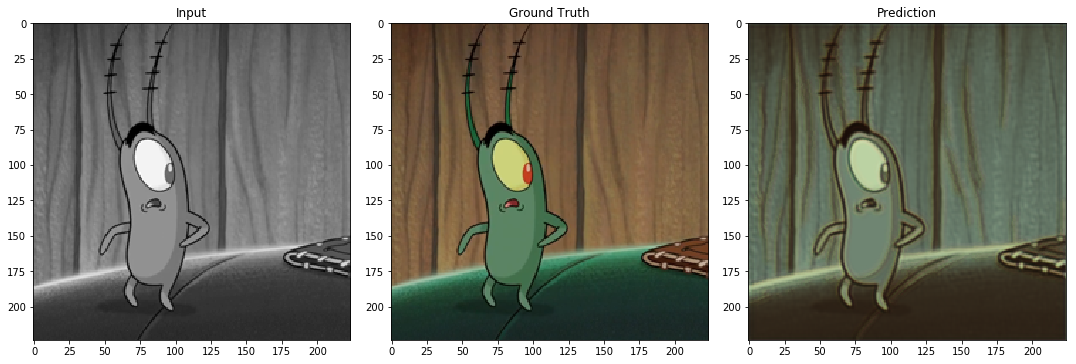

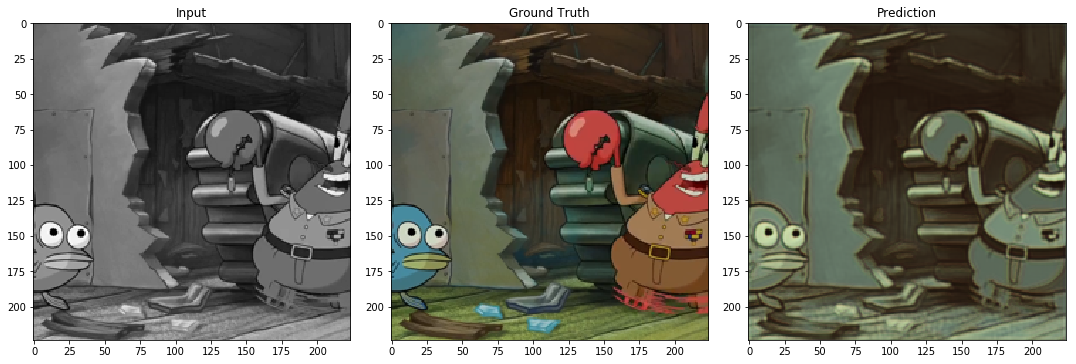

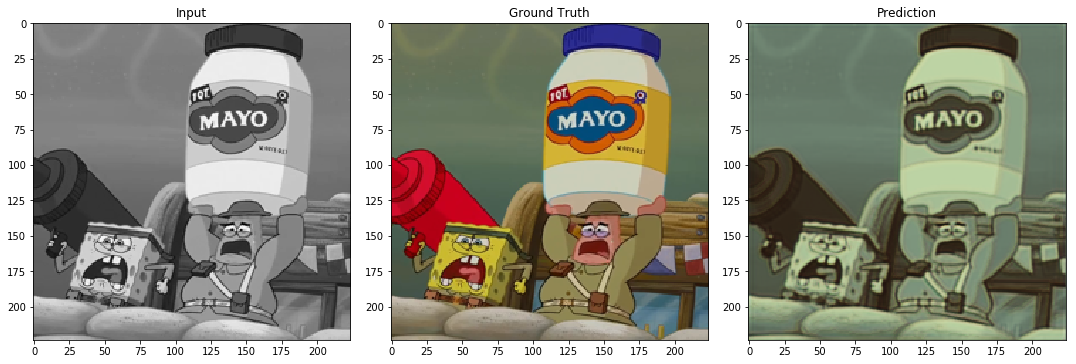

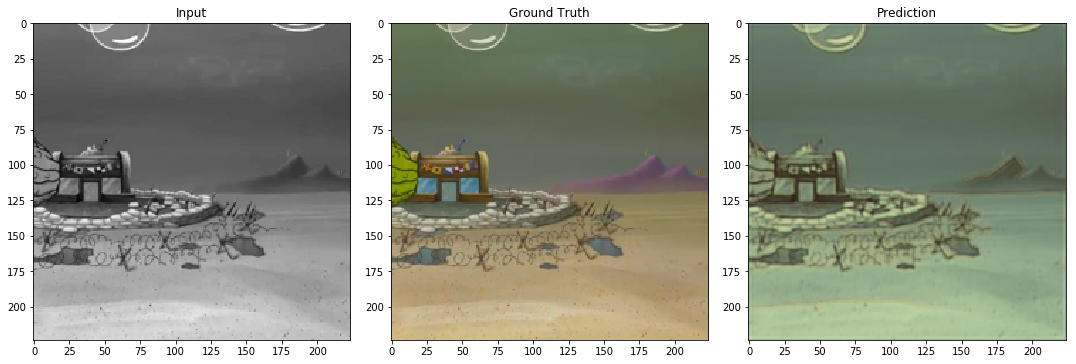

In [30]:
import random as r
import skimage
for n in range(20):
    i = int(r.random() * pred_u.shape[0])
    plt.figure(figsize=(15,10))

    plt.subplot(131)
    plt.title('Input')
    plt.imshow(x[i,:,:,0],cmap = 'gray')

    plt.subplot(132)
    plt.title('Ground Truth')
#     skimage.io.imshow(y[i]/255)
    skimage.io.imshow(y[i])
    plt.subplot(133)
    plt.title('Prediction')
#     plt.imshow(pred_u[i]/255)
     plt.imshow(pred_u[i])
    plt.show()